In [283]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from astropy.cosmology import default_cosmology

from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.SimulationAPI.ObservationConfig import Roman
from lenstronomy.Util import data_util

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.lenses import lens_util
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import lenstronomy_sim, survey_sim

In [284]:
pickle_path = os.path.join(config.machine.dir_00, 'detectable_gglenses_00.pkl')  # detectable_gglenses_01
detectable_gglenses = util.unpickle(pickle_path)

print(f'{len(detectable_gglenses)} detectable lens(es)')

110 detectable lens(es)


In [285]:
bands = ['F106', 'F129', 'F184']

In [286]:
sample_gglens = np.random.choice(detectable_gglenses)
# sample_gglens = detectable_gglenses[0]
sample_lens = lens_util.slsim_lens_to_mejiro(sample_gglens, bands=bands, cosmo=default_cosmology.get())

pprint(sample_lens.lens_mags)
pprint(sample_lens.source_mags)

{'F106': 20.06993237571269,
 'F129': 19.748270640087483,
 'F184': 19.325557564611948}
{'F106': 21.632414016880386,
 'F129': 21.40430841813276,
 'F184': 21.074642539961655}


In [287]:
lens_count_dict, source_count_dict = {}, {}

for band in bands:
    lens_count_dict[band] = sample_lens.get_lens_flux_cps(band)
    source_count_dict[band] = sample_lens.get_source_flux_cps(band)

pprint(lens_count_dict)
pprint(source_count_dict)

{'F106': 353.2051682330606,
 'F129': 457.8168195090884,
 'F184': 446.4542629416832}
{'F106': 83.75956115277975,
 'F129': 99.60396631539031,
 'F184': 89.15444155396452}


In [288]:
from lenstronomy.Util import data_util

lens_mag_dict, source_mag_dict = {}, {}

ab_zeropoints = {
    'F062': 26.99,
    'F087': 26.39,
    'F106': 26.41,
    'F129': 26.35,
    'F158': 26.41,
    'F184': 25.96
}

for band in bands:
    lens_mag_dict[band] = data_util.cps2magnitude(lens_count_dict[band], ab_zeropoints[band])
    source_mag_dict[band] = data_util.cps2magnitude(source_count_dict[band], ab_zeropoints[band])

pprint(lens_mag_dict)
pprint(source_mag_dict)

{'F106': 20.039932375712688,
 'F129': 19.698270640087486,
 'F184': 19.33555756461195}
{'F106': 21.602414016880385,
 'F129': 21.354308418132764,
 'F184': 21.084642539961656}


In [289]:
num_pix = 45
side = 4.95

arrays = []
lens_surface_brightness_list = []
source_surface_brightness_list = []

for band in tqdm(bands):
    model, lens_surface_brightness, source_surface_brightness = sample_lens.get_array(num_pix, side, band, return_pieces=True)
    arrays.append(model)
    lens_surface_brightness_list.append(lens_surface_brightness)
    source_surface_brightness_list.append(source_surface_brightness)

100%|██████████| 3/3 [00:00<00:00, 342.88it/s]


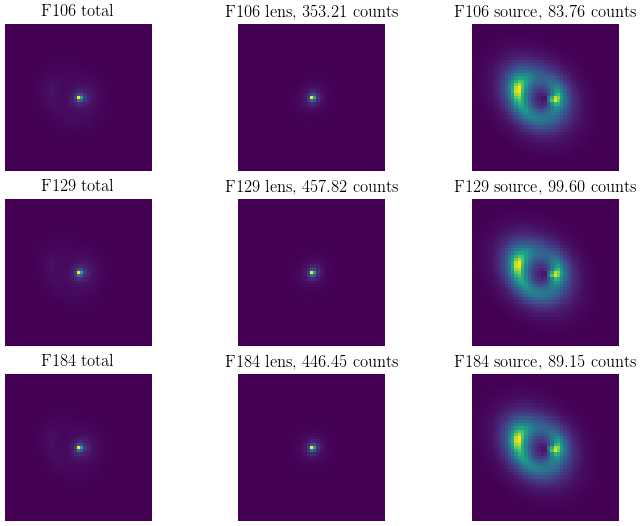

In [290]:
f, ax = plt.subplots(3, 3, constrained_layout=True)
for i, (band, array) in enumerate(zip(bands, arrays)):
    ax[i, 0].imshow(array)
    ax[i, 0].set_title(f'{band} total')
    ax[i, 0].axis('off')
    
    ax[i, 1].imshow(lens_surface_brightness_list[i])
    ax[i, 1].set_title(f'{band} lens, {lens_count_dict[band]:.2f} counts')
    ax[i, 1].axis('off')
    
    ax[i, 2].imshow(source_surface_brightness_list[i])
    ax[i, 2].set_title(f'{band} source, {source_count_dict[band]:.2f} counts')
    ax[i, 2].axis('off')

plt.show()

In [291]:
from mejiro.helpers import gs

results, lenses, sources, execution_time = gs.get_images(sample_lens, 
                                                         arrays, 
                                                         bands, 
                                                         input_size=45, 
                                                         output_size=45, 
                                                         grid_oversample=1, 
                                                         psf_oversample=1,
                                                         lens_surface_brightness=lens_surface_brightness_list, 
                                                         source_surface_brightness=source_surface_brightness_list,
                                                         detector=1, 
                                                         detector_pos=(2048, 2048),
                                                         exposure_time=146, 
                                                         ra=30, dec=-30, 
                                                         seed=42, 
                                                         validate=False, 
                                                         suppress_output=False, 
                                                         check_cache=True)

Loading cached PSF: /nfshome/bwedig/mejiro/mejiro/data/cached_psfs/F106_1_2048_2048_1.pkl
Loading cached PSF: /nfshome/bwedig/mejiro/mejiro/data/cached_psfs/F129_1_2048_2048_1.pkl
Loading cached PSF: /nfshome/bwedig/mejiro/mejiro/data/cached_psfs/F184_1_2048_2048_1.pkl


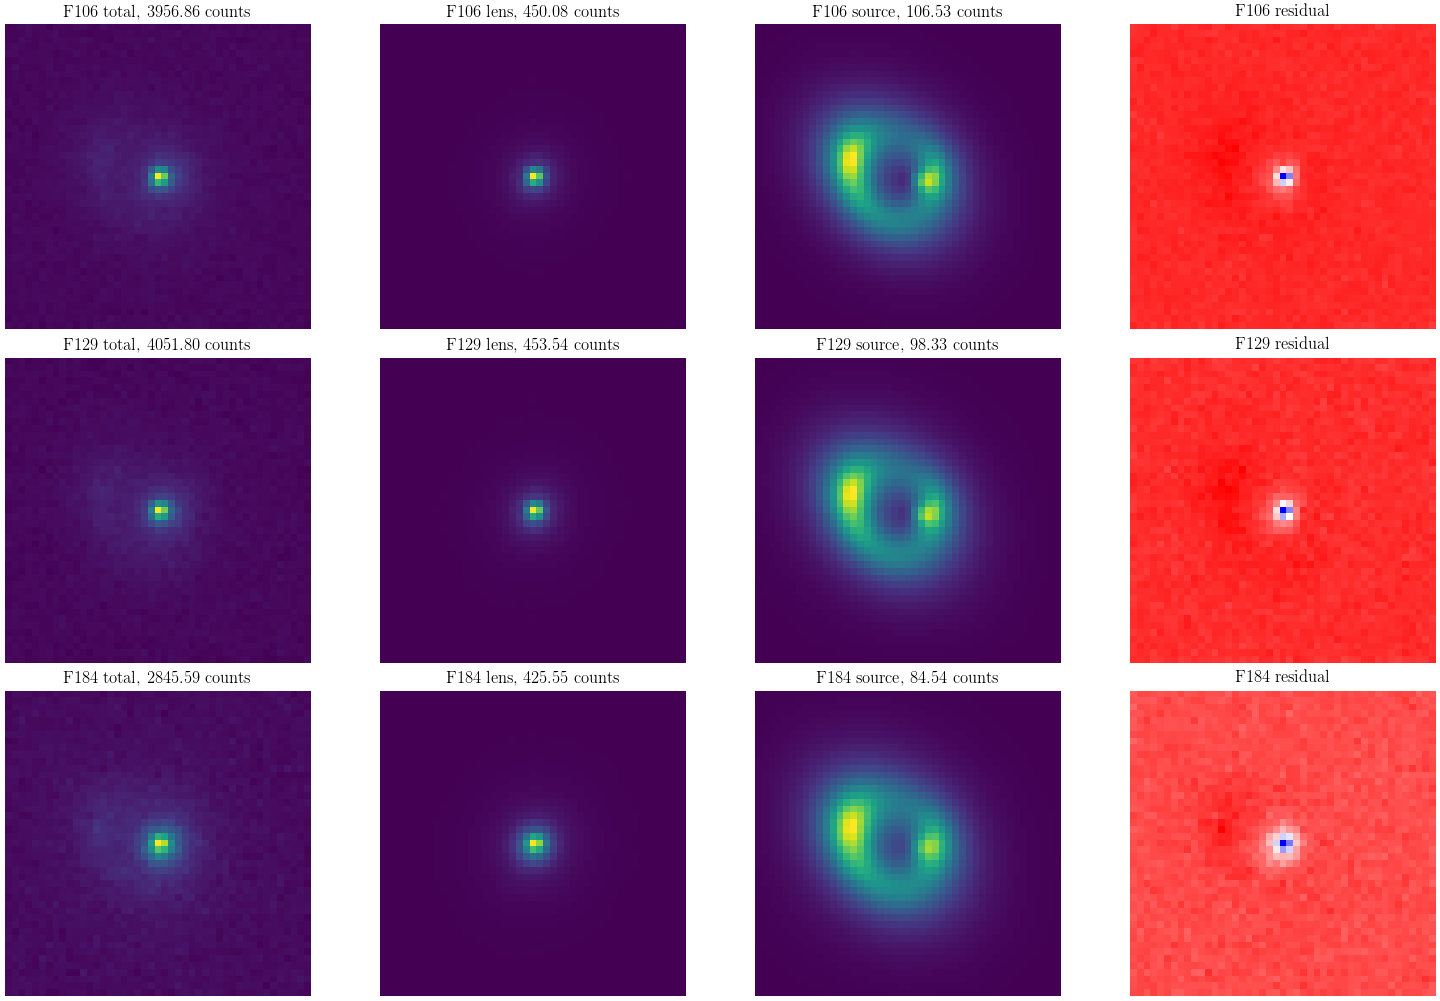

In [292]:
f, ax = plt.subplots(3, 4, constrained_layout=True, figsize=(15, 10))
for i, (band, array) in enumerate(zip(bands, results)):
    ax[i, 0].imshow(array)
    ax[i, 0].set_title(f'{band} total, {np.sum(array):.2f} counts')
    ax[i, 0].axis('off')
    
    ax[i, 1].imshow(lenses[i])
    ax[i, 1].set_title(f'{band} lens, {np.sum(lenses[i]):.2f} counts')
    ax[i, 1].axis('off')
    
    ax[i, 2].imshow(sources[i])
    ax[i, 2].set_title(f'{band} source, {np.sum(sources[i]):.2f} counts')
    ax[i, 2].axis('off')

    ax[i, 3].imshow(array - (lenses[i] + sources[i]), cmap='bwr')
    ax[i, 3].set_title(f'{band} residual')
    ax[i, 3].axis('off')
plt.show()

In [293]:
source = sources[0]
total_image = results[0] - lenses[0]

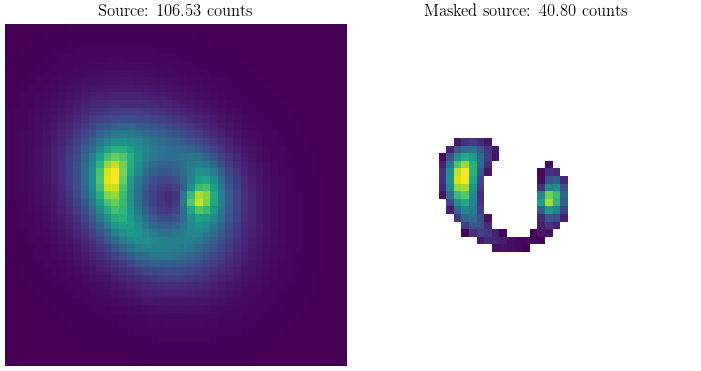

In [294]:
mask_mult = 2.

all_source_counts = np.sum(source)

# set mask threshold to define region of pixels to mask
stdev = np.std(source)
mean = np.mean(source)
threshold = mean + (mask_mult * stdev)

# mask source
masked_source = np.ma.masked_where(source < threshold, source)
source_counts = masked_source.compressed().sum()

percent_counts = 100 * source_counts / all_source_counts

f, ax = plt.subplots(1, 2, constrained_layout=True)
ax[0].imshow(source)
ax[0].set_title(f'Source: {np.sum(source):.2f} counts')
ax[1].imshow(masked_source)
ax[1].set_title(f'Masked source: {source_counts:.2f} counts')
for a in ax: a.axis('off')
plt.show()

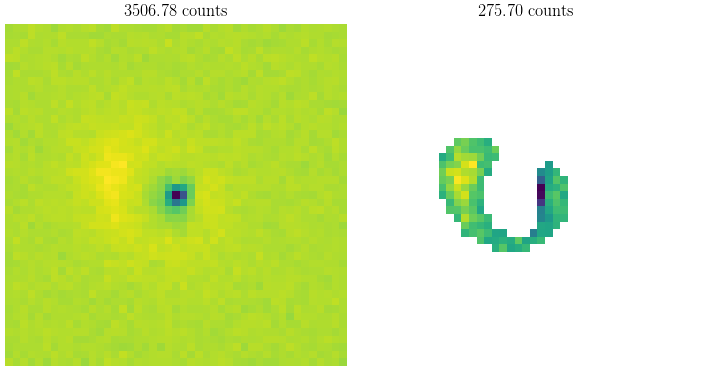

In [295]:
masked_total_image = np.ma.array(mask=masked_source.mask, data=total_image)
total_counts = masked_total_image.compressed().sum()

f, ax = plt.subplots(1, 2, constrained_layout=True)
ax[0].imshow(total_image)
ax[0].set_title(f'{np.sum(total_image):.2f} counts')
ax[1].imshow(masked_total_image)
ax[1].set_title(f'{total_counts:.2f} counts')
for a in ax: a.axis('off')
plt.show()

In [296]:
snr = source_counts / np.sqrt(total_counts)

print(f'Source counts: {source_counts:.2f}')
print(f'Total counts: {total_counts:.2f}')
print(f'SNR: {snr:.2f}')

Source counts: 40.80
Total counts: 275.70
SNR: 2.46


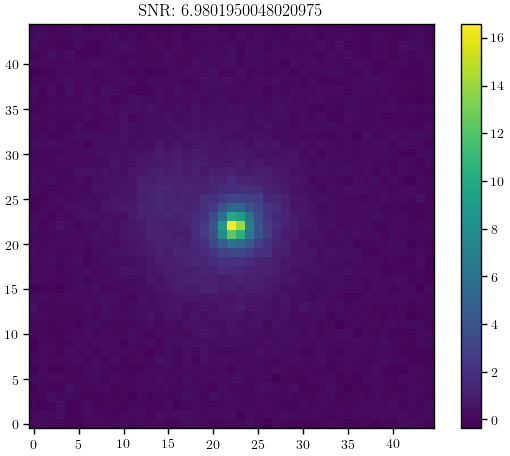

In [297]:
snr, total_image_with_noise = survey_sim.get_snr(sample_gglens, band, mask_mult=mask_mult)

plt.imshow(total_image_with_noise)
plt.title(f'SNR: {snr}')
plt.colorbar()
plt.show()